# Checking DHW nd DHM scripts using current coraltemp satellite data


Potential issues to think about:
* DHM v. DHW and associated different MMM algorithms
* William uses nightime data only. CMIP Models are at best deaily mean. A night-time mean shoudl not be too far from teh daily mean, but there will presimably be a slight cold bias. Chris Merchan uses 10am in CCI SST as a bst single time estimate of daily mean.
* The climatological period for DHW (1985 - 2012) starts just after an El Nino and ends just before an ENSO, so is rather anomolos because it only contains one ENSO event. A climatology from a free-running model run of the smae length is likley to contain more ENEl Nino events, therefore one could argue is more likely to be biased high, meaning that teh DHW values calculated would be lower than reality
* The 1997-1998 El Nino (captured by the DHW MMM climatology period) was anomalously big, so statistically a free-running model run, even with perfect ENSO simulation would likely have a lower MMM than observed, wich would make the DHW values calculate from the model higher than reality
   ** Note, the standardising year of 1988.3 is chosen for DHW because it allows them to match a precious climatological period
    which would not necessarily be a sensble year to use given model metholology
    


In [1]:
import iris
import iris.coord_categorisation
import matplotlib.pyplot as plt
import numpy as np
import iris.quickplot as qplt
import netCDF4
import datetime
import scipy
import scipy.signal
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import t
import pickle
import os
import glob





/Users/ph290/miniconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
def extract_region(cube,lon_west,lon_east,lat_south,lat_north):
    cube_region_tmp = cube.intersection(longitude=(lon_west, lon_east))
    cube_region = cube_region_tmp.intersection(latitude=(lat_south, lat_north))
    return cube_region

In [70]:
def area_avg(cube):
    try:
        cube.coord('latitude').guess_bounds()
        cube.coord('longitude').guess_bounds()
    except:
        pass
    grid_areas = iris.analysis.cartography.area_weights(cube)
    return cube.collapsed(['longitude','latitude'],iris.analysis.MEAN, weights=grid_areas)


def area_avg_not_weighted(cube):
    return cube.collapsed(['longitude','latitude'],iris.analysis.MEAN)



def area_max(cube):
    return cube.collapsed(['longitude','latitude'],iris.analysis.MAX)

In [4]:

def linregress_3D(y_array):
    # y_array is a 3-D array formatted like (time,lon,lat)
    # The purpose of this function is to do linear regression using time series of data over each (lon,lat) grid box with consideration of ignoring np.nan
    # Construct x_array indicating time indexes of y_array, namely the independent variable.
    x_array=np.empty(y_array.shape)
    for i in range(y_array.shape[0]): x_array[i,:,:]=i+1 # This would be fine if time series is not too long. Or we can use i+yr (e.g. 2019).
    x_array[np.isnan(y_array)]=np.nan
    # Compute the number of non-nan over each (lon,lat) grid box.
    n=np.sum(~np.isnan(x_array),axis=0)
    # Compute mean and standard deviation of time series of x_array and y_array over each (lon,lat) grid box.
    x_mean=np.nanmean(x_array,axis=0)
    y_mean=np.nanmean(y_array,axis=0)
    x_std=np.nanstd(x_array,axis=0)
    y_std=np.nanstd(y_array,axis=0)
    # Compute co-variance between time series of x_array and y_array over each (lon,lat) grid box.
    cov=np.nansum((x_array-x_mean)*(y_array-y_mean),axis=0)/n
    # Compute correlation coefficients between time series of x_array and y_array over each (lon,lat) grid box.
    cor=cov/(x_std*y_std)
    # Compute slope between time series of x_array and y_array over each (lon,lat) grid box.
    slope=cov/(x_std**2)
    # Compute intercept between time series of x_array and y_array over each (lon,lat) grid box.
    intercept=y_mean-x_mean*slope
    # Compute tstats, stderr, and p_val between time series of x_array and y_array over each (lon,lat) grid box.
    tstats=cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr=slope/tstats
    p_val=t.sf(tstats,n-2)*2
    # Compute r_square and rmse between time series of x_array and y_array over each (lon,lat) grid box.
    # r_square also equals to cor**2 in 1-variable lineare regression analysis, which can be used for checking.
    r_square=np.nansum((slope*x_array+intercept-y_mean)**2,axis=0)/np.nansum((y_array-y_mean)**2,axis=0)
    rmse=np.sqrt(np.nansum((y_array-slope*x_array-intercept)**2,axis=0)/n)
    # Do further filteration if needed (e.g. We stipulate at least 3 data records are needed to do regression analysis) and return values
    n=n*1.0 # convert n from integer to float to enable later use of np.nan
    n[n<3]=np.nan
    slope[np.isnan(n)]=np.nan
    intercept[np.isnan(n)]=np.nan
    p_val[np.isnan(n)]=np.nan
    r_square[np.isnan(n)]=np.nan
    rmse[np.isnan(n)]=np.nan
#     return n,slope,intercept,p_val,r_square,rmse
    return slope,intercept

## Defining DHW, DHM and their MMM climatologies

### DHW MMM (Skirving definition):

* The MMM is calculated from 1985-2012 inclusive
* The data from the above period is averaged from daily to monthly
* Each calendar month from the 1985-2012 period (i.e. initially all Jans) are taken. Each grid point has a linear trend fitted to it through time, then the value coresponding to 1988.2857 on that linar trend is assigned to that grid point for that month. This is done for each claendar month. Now you have 12 2d fields, one for each month.
* Take the maximum of the 12 values for each pixel. This is the DHW MMM.

### DHM MMM (Donner method):

* The MMM is calculated from 1985 - 2000 inclusive
* The data from the above period is averaged from daily to monthly
* The data is NOT detrended
* The maximum monthly mean value at each point is taken over that interval.

*NOTE The DHM MMM should statistically be considerably higher than then DHW MMM becuase it does not remove climate change and will be weighted towards finding warmest montsh towards the latter part of the climatology period, whereas the DHW MMM attempts to adjust eveything to 1988.3 which falls towards teh start of teh period.*

### DHW (Skirving definition):

* Working with daily data 
* Using the DHW MMM defined above, subtract the MMM from each daily timestep over your analysis period
* After the subtraction described above, **set all values less than 1 to 0**.
* for each point in space and time, look back over an 84 day window (no. days in **3 months**: 7 days * 4 weeks * 3 months), and sum up the values and asign the sum to the current day. i.e. sum up over anomalies a 3 month rolling window.
* **Divide by 7 to do from DHdays to DHweeks**

### DHM (Donner definition):

* Working with monthly data 
* Using the DHM MMM defined above, subtract the MMM from each daily timestep over your analysis period
* After the subtraction described above, **set all values less than 0 to 0**.
* for each point in space and time, look back over an **4 month window**  and sum up the values and asign the sum to the current month. i.e. sum up over anomalies a 4 month rolling window.



In [5]:
#DHM - 1985-2000

# https://rmets.onlinelibrary.wiley.com/doi/pdf/10.1002/joc.3486
# the monthly data set for 1982 – 2006 was first detrended using a linear regression, calculated for each month of the year and grid cell. The data set was detrended and centred on 1988
# I don't like this - it becoes ver deending on whether 1988 is a warm or cold year/...

def mmm_for_dhm(cube):
    years_for_mmm_climatology = [1985,2000]
    #####################################################
    #Avreage months separately!!!!!!!!!!!
#####################################################
    cube_years = cube.coord('year').points
    #subset the data into the bit you want to use to calculate the MMM climatology and the bit you want to calculate DHW on
    clim_cube = cube[np.where((cube_years >= years_for_mmm_climatology[0]) & (cube_years <= years_for_mmm_climatology[1]))]
    #collapse the months together, taking the maximum value at each lat-lon grid square
    mmm_climatology = clim_cube.collapsed('time',iris.analysis.MAX)
    return mmm_climatology



def mmm_skirving(cube):
    cube = cube.aggregated_by(['year','month'], iris.analysis.MEAN)
    print 'calculating NOAA Skirving MMM for month:'
#     missing_data_value_greater_than = -32768.0
#     missing_data_equals = -32768.0
    missing_data_equals = cube.data.fill_value
    print 'NOTE THIS SHOULD IDEALLY BE USING AN AVERAGE OF NIGHTIME TEMPERATURES, WHICH IS NOT A BED ESTIMATE FOR DAILY MEAN. A GOOD ALTERNATIEV FOR DAILY MEAN IS 10am (whet chris merchant does)'
    years_for_mmm_climatology = [1985,2012]
    standardisation_date = 1988.2857
    mm_cube = cube[0:12].copy()
    mm_cube_data = mm_cube.data.copy()
    cube_years = cube.coord('year').points
    #subset the data into the bit you want to use to calculate the MMM climatology and the bit you want to calculate DHW on
    clim_cube = cube[np.where((cube_years >= years_for_mmm_climatology[0]) & (cube_years <= years_for_mmm_climatology[1]))]
    clim_cube_detrended = clim_cube.copy()
    clim_cube_detrended_data = clim_cube_detrended.data
    print np.shape(clim_cube_detrended)
    for i,month in enumerate(np.unique(cube.coord('month_number').points)):
        print i+1
        loc = np.where(clim_cube.coord('month_number').points == month)
        tmp = clim_cube_detrended_data[loc,:,:][0]
        tmp[np.where(tmp == missing_data_equals )] = np.nan
        slope,intercept = linregress_3D(tmp)
        x = standardisation_date - years_for_mmm_climatology[0]
        y = (slope * x ) + intercept
        mm_cube_data[i,:,:] = y
    mm_cube.data = mm_cube_data
    mmm_climatology = mm_cube.collapsed('time',iris.analysis.MAX)
    return mmm_climatology

In [6]:
def dhm(cube,mmm_climatology,years_over_which_to_calculate_dhm):
    missing_data_value = cube.data.fill_value
    #This hsould be given monthly data
    # One DHM == 4DHW This is important
#     mmm is straight averg not fdetreneded for DHM
    #Look at the donna poapers - look over two papers...
    #accumulation window is 4 months rather than 3 months.
    cube_years = cube.coord('year').points
#     print cube_years
#     print years_over_which_to_calculate_dhm[0]
#     print years_over_which_to_calculate_dhm[1]
    main_cube = cube[np.where((cube_years >= years_over_which_to_calculate_dhm[0]) & (cube_years <= years_over_which_to_calculate_dhm[1]))]
    main_cube_data = main_cube.data.copy()
    main_cube_data[np.where(main_cube_data == missing_data_value )] = np.nan
    main_cube.data = main_cube_data
    
    #subtract the monthly mean climatology from the rest of the data
    main_cube -= mmm_climatology # at this stage this is called a hot spot (which is anything greater than the mmm)

    #set all values less than 1 to zero
#     main_cube.data[np.where(main_cube.data <= 1.0)] = 0.0
    #OR
    main_cube_data = main_cube.data.copy()
    main_cube_data[np.where(main_cube_data < 0.0)] = 0.0
#     main_cube_data[np.where(main_cube_data == missing_data_value )] = np.nan
    main_cube.data = main_cube_data
    
    #make a cube to hold the output data
    output_cube = main_cube[3::].copy()
    output_cube.data[:] = np.nan
    output_cube_data = output_cube.data.copy()

        #AVEREG OVER A 4 month  window rather than 3 month when it comes to DHW


    #loop through from day 112 to the end of the dataset
    for i in range(output_cube.shape[0]):
#         print i,' of ',output_cube.shape[0]
        tmp_data = main_cube[i:i+4].collapsed('time',iris.analysis.SUM)
        output_cube_data[i,:,:] = tmp_data.data

    #save the output
    output_cube.data = output_cube_data
    return output_cube

In [7]:
def dhw(cube,mmm_climatology,years_over_which_to_calculate_dhw):
    cube_years = cube.coord('year').points
    #note this is to be uef with daily data...
    main_cube = cube[np.where((cube_years > years_over_which_to_calculate_dhw[0]) & (cube_years < years_over_which_to_calculate_dhw[1]))]
    #subtract the monthly mean climatology from the rest of the data
    main_cube -= mmm_climatology
    #set all values less than 1 to zero
    main_cube.data[np.where(main_cube.data < 1.0)] = 0.0 

    #make a cube to hold the output data
    output_cube = main_cube[83::].copy()
    output_cube.data[:] = np.nan
    output_cube_data = output_cube.data.copy()

    #loop through from day 84 to the end of the dataset
    for i in range(output_cube.shape[0]):
#         print i,' of ',output_cube.shape[0]
        #sum the temperatures in that 84 day window and divide result by 7 to get in DHWeeks rather than DHdays
        tmp_data = main_cube[i:i+84].collapsed('time',iris.analysis.SUM)/7.0
        output_cube_data[i,:,:] = tmp_data.data

    #save the output
    output_cube.data = output_cube_data
    return output_cube

# Read in satilite data

In [8]:
directory = '/Users/ph290/Downloads/dhw/'

files = glob.glob(directory+'coraltemp_v1.0_region.nc')
cube = iris.load_cube(files,'sea_surface_temperature')

try:
    iris.coord_categorisation.add_year(cube, 'time', name='year')
    iris.coord_categorisation.add_month(cube, 'time', name='month')
    iris.coord_categorisation.add_month_number(cube, 'time', name='month_number')
    iris.coord_categorisation.add_day_of_month(cube, 'time', name='day_of_month')
except:
    pass

/Users/ph290/miniconda2/lib/python2.7/site-packages/iris/fileformats/cf.py:1143: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)
/Users/ph290/miniconda2/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1953: UserWarning: Failed to create 'time' dimension coordinate: The points array must be strictly monotonic.
Gracefully creating 'time' auxiliary coordinate instead.
  error=e_msg))


In [9]:
cube_monthly = cube.aggregated_by(['year','month'], iris.analysis.MEAN)

In [10]:
# def my_callback(cube, field,files_tmp):
#     # there are some bad attributes in the NetCDF files which make the data incompatible for merging.
#     cube.attributes.pop('time_coverage_end')
#     cube.attributes.pop('date_issued')
#     cube.attributes.pop('time_coverage_start')


# directory = '/data/BatCaveNAS/ph290/obs/crw_sst/'
# files = glob.glob(directory+'coraltemp_v1.0_*.nc')
# cubes = iris.load(files,'sea_surface_temperature',callback=my_callback)
# # import irisexperimental
# # import iris.experimental.equalise_cubes
# # import 
# # iris.util.unify_time_units(cubes)
# # iris.experimental.equalise_cubes.equalise_attributes(cubes)
# cube = cubes.concatenate_cube()
# # cube = iris.load_cube(files[0],'sea_surface_temperature')
# try:
#     iris.coord_categorisation.add_year(cube, 'time', name='year')
#     iris.coord_categorisation.add_month(cube, 'time', name='month')
#     iris.coord_categorisation.add_month_number(cube, 'time', name='month_number')
#     iris.coord_categorisation.add_day_of_month(cube, 'time', name='day_of_month')
# except:
#     pass
    
# # print cubes[0].coord('time')
# print cube.coord('day_of_month').points

# Calculate DHW

In [11]:
lon_west = 142.0
lon_east = 157.0
lat_south = -30.0
lat_north = -10.0

years_over_which_to_calculate_dhw = [2012,2019]
# cube_region = extract_region(cube,lon_west,lon_east,lat_south,lat_north)
cube_region = extract_region(cube,lon_west,lon_east,lat_south,lat_north)



In [15]:
mmm_climatology_dhw = mmm_skirving(cube_region)
dhw_cube_gbr = dhw(cube_region,mmm_climatology_dhw,years_over_which_to_calculate_dhw)

calculating NOAA Skirving MMM for month:
NOTE THIS SHOULD IDEALLY BE USING AN AVERAGE OF NIGHTIME TEMPERATURES, WHICH IS NOT A BED ESTIMATE FOR DAILY MEAN. A GOOD ALTERNATIEV FOR DAILY MEAN IS 10am (whet chris merchant does)
(336, 400, 300)
1


/Users/ph290/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:42: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


2
3
4
5
6
7
8
9
10
11
12


In [16]:
cube_region_monthly = cube_region.aggregated_by(['month','year'], iris.analysis.MEAN)
mmm_climatology_dhm = mmm_for_dhm(cube_region_monthly)
dhm_cube_gbr_monthly = dhm(cube_region_monthly,mmm_climatology_dhm,years_over_which_to_calculate_dhw)



### masking land points

In [27]:
dhw_cube_gbr.data = np.ma.masked_array(dhw_cube_gbr.data)
dhw_cube_gbr.data.mask = cube_region.data.mask


In [26]:
def asb(cube,threshold):
    dhvalue_cube_gbr_tmp = cube.copy()
    dhvalue_cube_gbr_tmp_data = dhvalue_cube_gbr_tmp.data
    dhvalue_cube_gbr_tmp_data[np.where(dhvalue_cube_gbr_tmp_data <= threshold)] = 0.0
    dhvalue_cube_gbr_tmp_data[np.where(dhvalue_cube_gbr_tmp_data > threshold)] = 1.0
    dhvalue_cube_gbr_tmp.data = dhvalue_cube_gbr_tmp_data
    dhvalue_cube_gbr_asb = dhvalue_cube_gbr_tmp.copy()
    dhvalue_cube_gbr_asb = dhvalue_cube_gbr_tmp.aggregated_by(['year'], iris.analysis.SUM)
    dhvalue_cube_gbr_asb_tmp = dhvalue_cube_gbr_asb.data
    dhvalue_cube_gbr_asb_tmp[np.where(dhvalue_cube_gbr_asb_tmp > 1.0)] = 1.0
    dhvalue_cube_gbr_asb.data = dhvalue_cube_gbr_asb_tmp
    return dhvalue_cube_gbr_asb


dhw_cube_gbr.data = np.ma.masked_where(dhw_cube_gbr.data == dhw_cube_gbr.data.fill_value,dhw_cube_gbr.data)


# dhm_cube_gbr = extract_region(dhm_cube_gbr,lon_west,lon_east,lat_south,lat_north)
dhw_cube_gbr_asb = asb(dhw_cube_gbr,8.0)
dhw_cube_gbr_asb_area_avg = area_avg(dhw_cube_gbr_asb)
dhw_cube_gbr.data[np.where(dhw_cube_gbr.data == 0.0)] = np.nan
dhw_avg = area_avg(dhw_cube_gbr.aggregated_by(['year'], iris.analysis.MEAN))


dhm_cube_gbr_asb_monthly = asb(dhm_cube_gbr_monthly,2.0)
dhm_cube_gbr_asb_area_avg_monthly = area_avg(dhm_cube_gbr_asb_monthly)
dhm_avg_monthly = area_avg(dhm_cube_gbr_monthly.aggregated_by(['year'], iris.analysis.MEAN))




/Users/ph290/miniconda2/lib/python2.7/site-packages/iris/analysis/cartography.py:376: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")
/Users/ph290/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


## The following compares DHW and DHMs where the daily satilite data has been averaged to monthly prior to any DHM analysis

### Maximum **DHW** in each grid box over 2012-2019

/Users/ph290/miniconda2/lib/python2.7/site-packages/iris/coords.py:826: UserWarning: Coordinate u'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/Users/ph290/miniconda2/lib/python2.7/site-packages/iris/coords.py:826: UserWarning: Coordinate u'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


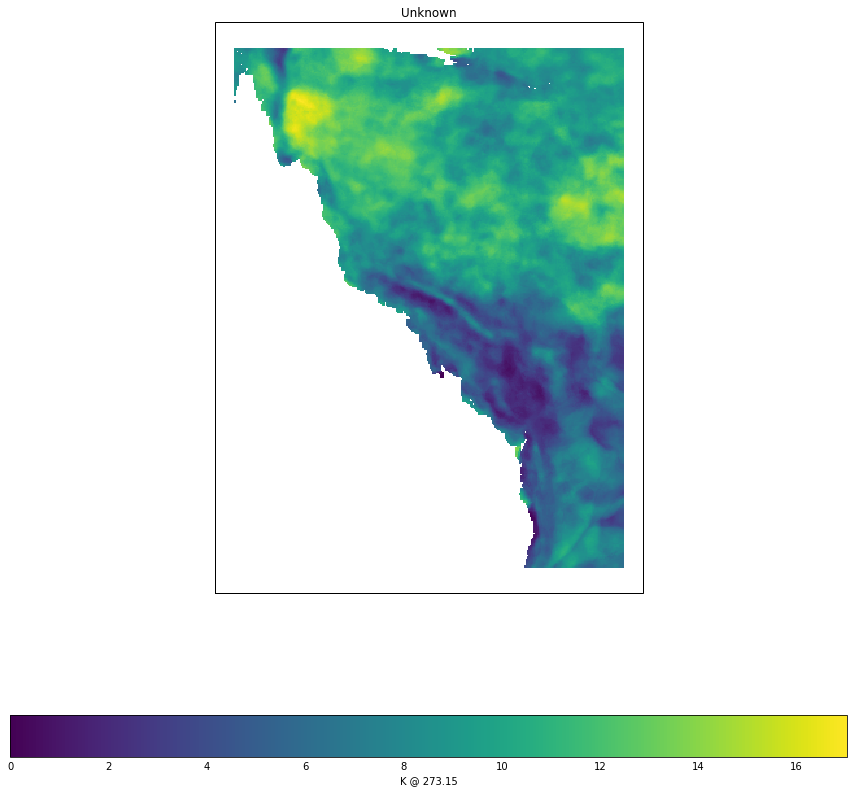

In [28]:
fig = plt.figure(figsize=(15, 15))
dhw_cube_gbr_max = dhw_cube_gbr.collapsed('time',iris.analysis.MAX)
qplt.pcolormesh(dhw_cube_gbr_max)


In [29]:
dhm_cube_gbr_max = dhm_cube_gbr_monthly.collapsed('time',iris.analysis.MAX)



### Maximum **DHM** in each grid box over 2012-2019

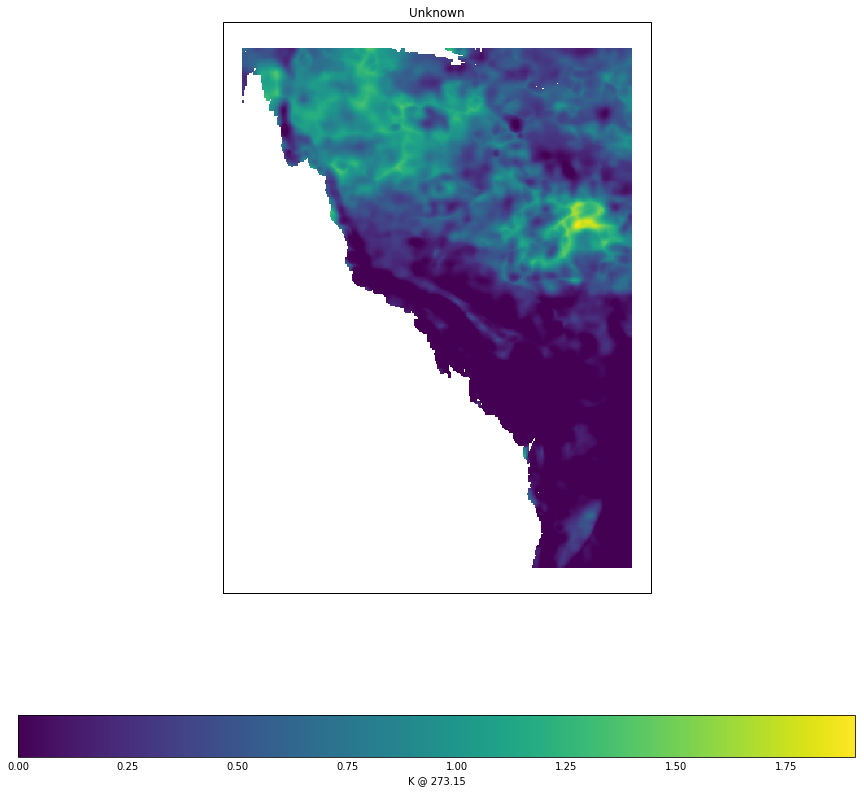

In [30]:
fig = plt.figure(figsize=(15, 15))
qplt.pcolormesh(dhm_cube_gbr_max)

### Time mean **DHW** in each grid box over 2012-2019

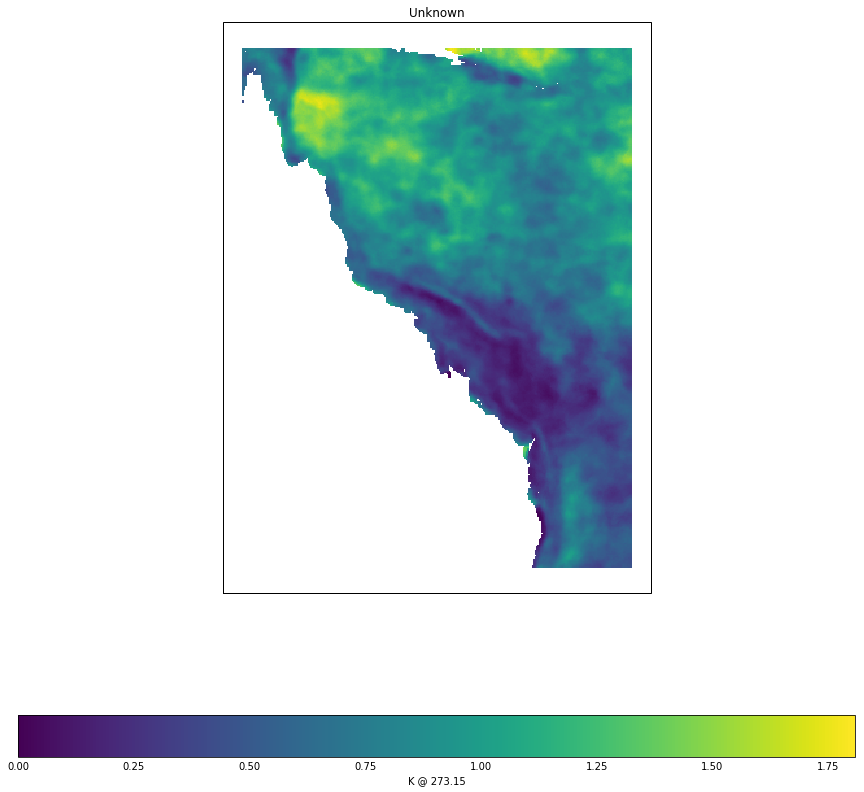

In [31]:
fig = plt.figure(figsize=(15, 15))
dhw_cube_gbr_mean = dhw_cube_gbr.collapsed('time',iris.analysis.MEAN)
qplt.pcolormesh(dhw_cube_gbr_mean)

### Time mean **DHM** in each grid box over 2012-2019

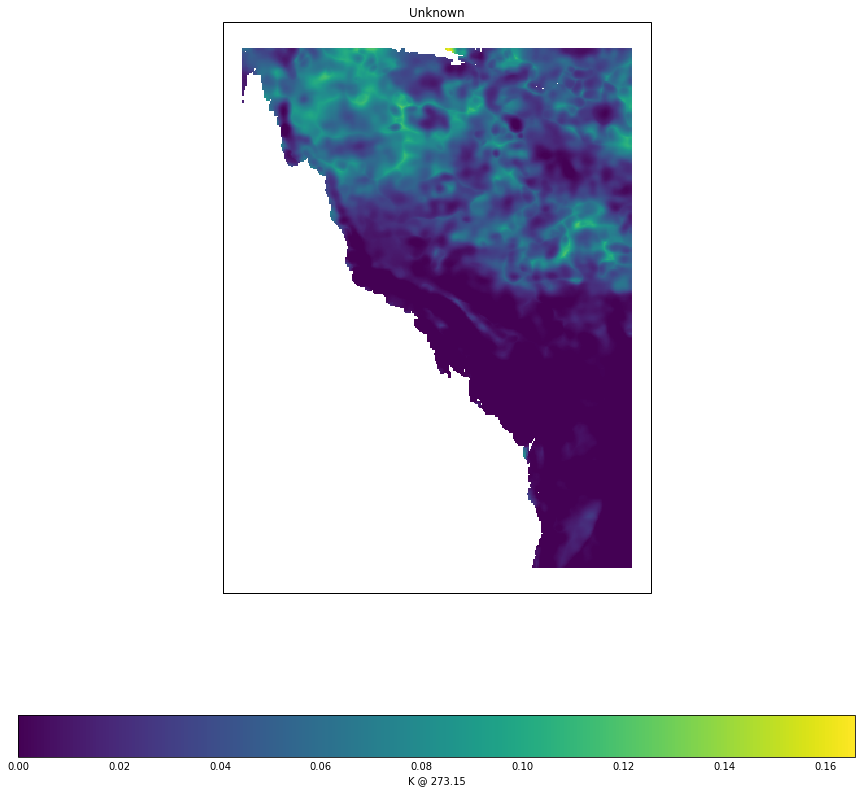

In [32]:
fig = plt.figure(figsize=(15, 15))
dhm_cube_gbr_mean = dhm_cube_gbr_monthly.collapsed('time',iris.analysis.MEAN)
qplt.pcolormesh(dhm_cube_gbr_mean)

In [33]:
dhw_avg = area_avg(dhw_cube_gbr.aggregated_by(['year'], iris.analysis.MEAN))
dhm_avg = area_avg(dhm_cube_gbr_monthly.aggregated_by(['year'], iris.analysis.MEAN))

dhw_max = area_max(dhw_cube_gbr.aggregated_by(['year'], iris.analysis.MAX))
dhm_max = area_max(dhm_cube_gbr_monthly.aggregated_by(['year'], iris.analysis.MAX))


/Users/ph290/miniconda2/lib/python2.7/site-packages/iris/coords.py:1017: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'latitude'.
  warnings.warn(msg.format(self.name()))
/Users/ph290/miniconda2/lib/python2.7/site-packages/iris/coords.py:1017: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'longitude'.
  warnings.warn(msg.format(self.name()))


### Average DHW and DHM in time and space in each grid box over 2012-2019, using region in above plots

Text(0.5,0,'year')

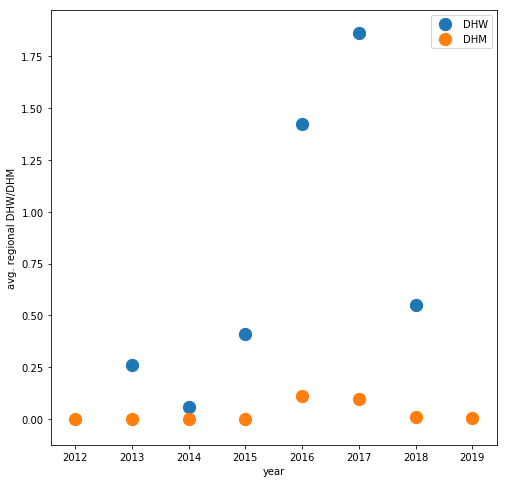

In [34]:
fig = plt.figure(figsize=(8, 8))
plt.scatter(dhw_avg.coord('year').points,dhw_avg.data,s=150,label='DHW')
plt.scatter(dhm_avg.coord('year').points,dhm_avg.data,s=150,label='DHM')
plt.ylabel('avg. regional DHW/DHM')
plt.legend()
plt.xlabel('year')

### Maximum DHW and DHM in time and space in each grid box over 2012-2019, using region in above plots

Text(0.5,0,'year')

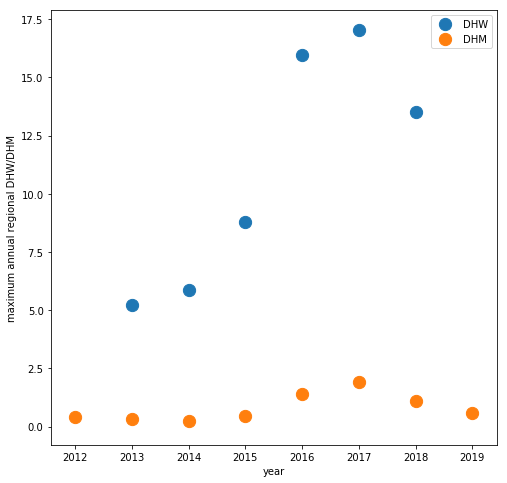

In [35]:
fig = plt.figure(figsize=(8, 8))
plt.scatter(dhw_avg.coord('year').points,dhw_max.data,s=150,label='DHW')
plt.scatter(dhm_avg.coord('year').points,dhm_max.data,s=150,label='DHM')
plt.ylabel('maximum annual regional DHW/DHM')
plt.legend()
plt.xlabel('year')

# As above but showing area averaged ASB. Note that the DHW and DHM are on two separate y-axes

The important thing to note as far as I'm concerned here is that based on satilite data averaged from daily to monthly, then applying the accepted DHM algorithms, there was no ASB over the observed period - the maximum DHW reached in any grid box over this interval (2017) was 1.9

Text(0.5,0,'year')

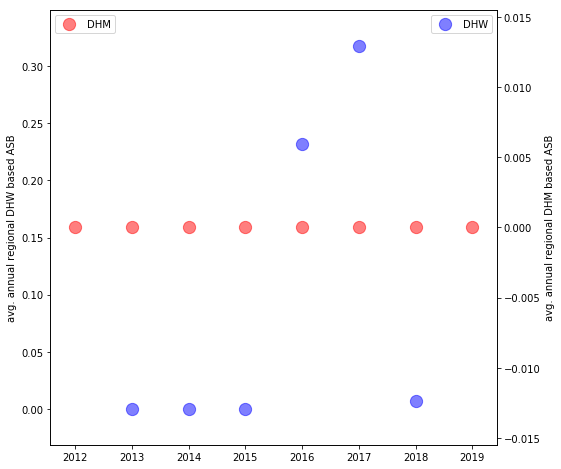

In [73]:
dhm_cube_gbr_asb_monthly = asb(dhm_cube_gbr_monthly,2.0)
dhm_cube_gbr_asb_area_avg_monthly = area_avg(dhm_cube_gbr_asb_monthly)

# fig = plt.figure(figsize=(8, 8))
fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.scatter(dhw_cube_gbr_asb_area_avg.coord('year').points,dhw_cube_gbr_asb_area_avg.data,color='b',s=150,label='DHW',alpha=0.5)
ax1.legend(loc=1)
ax2 = ax1.twinx() 
ax2.scatter(dhm_cube_gbr_asb_area_avg_monthly.coord('year').points,dhm_cube_gbr_asb_area_avg_monthly.data,color='r',s=150,label='DHM',alpha=0.5)
ax1.set_ylabel('avg. annual regional DHW based ASB')
ax2.set_ylabel('avg. annual regional DHM based ASB')
# ax2.set_ylim([-0.000001,0.000001])
ax2.legend(loc=2)
plt.xlabel('year')